## Business + Data Understanding

Gather necessary data to answer your questions

Handle categorical and missing data

Provide insight into the methods you chose and why you chose them

In [1]:
import datetime 
import math
import mplleaflet
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import statistics

from collections import defaultdict
from datetime import date, timedelta, datetime
from matplotlib.ticker import PercentFormatter
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

register_matplotlib_converters()
%matplotlib inline

In [2]:
listing_df = pd.read_csv('./listings_seattle.csv')
calendar_df = pd.read_csv('./calendar_seattle.csv')
reviews_df = pd.read_csv('./reviews_seattle.csv')

### Understanding the data

Starting with the listing_df file, we will look into its parameters and try to understand the data.

In [3]:
rows = listing_df.shape[0]
cols = listing_df.shape[1]

In [4]:
name_cols = listing_df.columns

In [5]:
cat_df = listing_df.select_dtypes(include=['object'])

In [6]:
#I created groups of columns with relevant information about a certain aspect of AirBnB's listings
#General Information
gen_cols = ['id', 'name']

#Text Description
text_cols = ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit']

#Host Info
host_cols = ['host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified']

#Location Info
loc_cols = ['street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 
       'smart_location', 'latitude', 'longitude',
       'is_location_exact']

#Apartment Info
apt_cols = ['property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']

#Price Info
price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people']

#Availability
aval_cols = ['minimum_nights', 'maximum_nights', 'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90',
       'availability_365']

#Reviews - Satisfaction
rev_cols = ['number_of_reviews', 
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']

#Booking
book_cols = ['instant_bookable', 'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification']


### Plotting the data

Helps visualizing and understanding the information. To understand which percentage of values falls into a certain category, I used bar plots and the relative frequency of each data point.

C:\Users\Tati\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


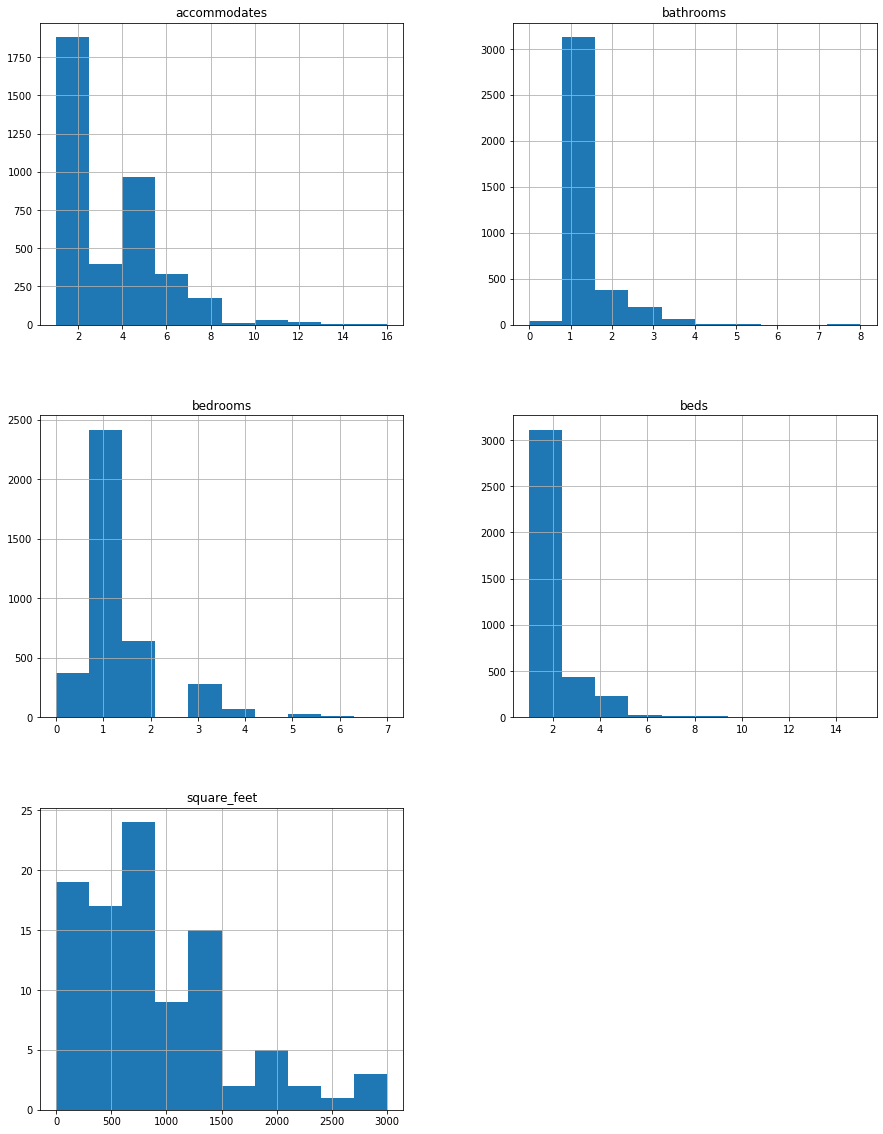

In [7]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
listing_df[apt_cols].hist(ax = ax);

In [8]:
def get_prop(df, col, sort='value'):
    if sort == 'value':
        return (df[col].value_counts().sort_values()/(df.shape[0]-sum(df[col].isnull())))
    elif sort == 'index':
        return (df[col].value_counts().sort_index()/(df.shape[0]-sum(df[col].isnull())))

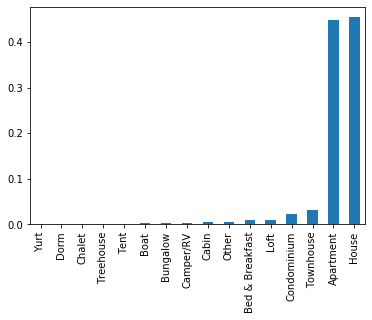

In [9]:
get_prop(listing_df, 'property_type').plot(kind='bar');

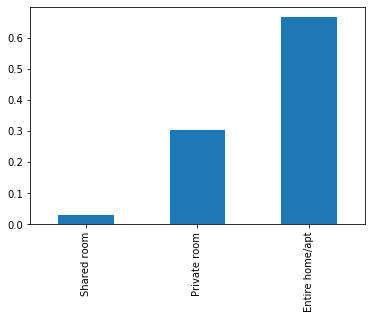

In [10]:
get_prop(listing_df, 'room_type').plot(kind='bar');

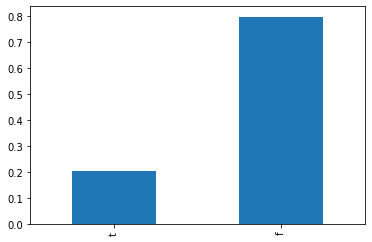

In [11]:
get_prop(listing_df, 'host_is_superhost').plot(kind='bar');

### Cleaning the data

First I will locate which columns can be deleted (i.e., with a single value). Then, I will analyse which columns have the highest percentage of missing values.

In [12]:
#Identifying and dropping columns with only one value

uni_cols = []

for col in listing_df.columns:
    if len(listing_df[col].unique()) == 1:
        uni_cols.append(col)
        listing_df = listing_df.drop(columns=[col])

In [13]:
#Checking for columns with > 25% missing values

for col in listing_df.columns:
    if listing_df[col].isnull().mean() > 0.25:
        print("The column {} has {:.1f}% of missing values".format(col , 100*listing_df[col].isnull().mean()))

The column neighborhood_overview has 27.0% of missing values
The column notes has 42.1% of missing values
The column square_feet has 97.5% of missing values
The column weekly_price has 47.4% of missing values
The column monthly_price has 60.3% of missing values
The column security_deposit has 51.1% of missing values
The column cleaning_fee has 27.0% of missing values


The price data is saved as a string. The next cells transform the relevant data points into floats.

In [14]:
#function was needed in order to try/except values; np.nan values cannot be transformed into float
def clean_price(x):
    try:
        return float(x.replace('$', '').replace(',', ''))
    except:
        return x

In [15]:
for col in price_cols:
    listing_df[col] = listing_df[col].apply(lambda x: clean_price(x))

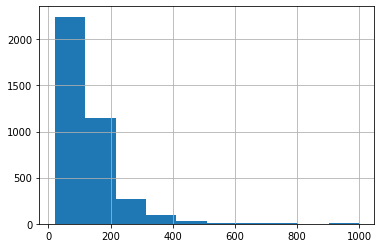

In [16]:
listing_df['price'].hist(bins=10);

The host_response_rate is also saved as a percentage string. We will also change it to numbers.

In [17]:
def clean_perc(x):
    try:
        return float(x.replace('%', ''))/100
    except:
        return x
    
listing_df['host_response_rate'] = listing_df['host_response_rate'].apply(lambda x: clean_perc(x))

Now it's time to clean multiple selection columns.

In [18]:
#Finding all possible values in a column with multiple value selection

find_unique = lambda x: x.replace("[", '').replace("]", '').replace(",", '')

unique_vals = list(set(listing_df['host_verifications'].apply(find_unique).str.cat(sep=' ').split(' ')))

In [19]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    for val in look_for:
        for row in range(df.shape[0]):
            if val in df[col1][row]:
                new_df[val] += int(df[col2][row])

    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values(col2, ascending=False, inplace=True)
    return new_df

In [20]:
possible_vals = unique_vals

def clean_and_plot(df, col, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df[col].value_counts().reset_index()
    study_df = total_count(study, 'index', col, possible_vals)
    study_df.set_index('index', inplace=True)
    
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df

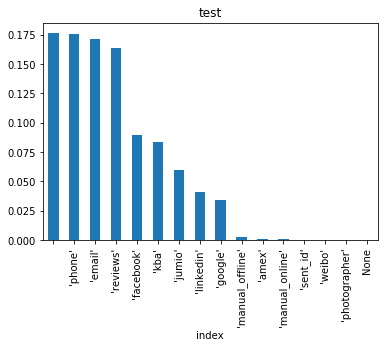

,host_verifications
index,
,0.176408
'phone',0.175161
'email',0.171233
'reviews',0.163979
'facebook',0.089082
'kba',0.083907
'jumio',0.059557
'linkedin',0.041168
'google',0.034422


In [21]:
clean_and_plot(listing_df, 'host_verifications', 'test')

In [22]:
listing_df.groupby('host_response_time').mean()['review_scores_rating']

host_response_time
a few days or more    87.793103
within a day          94.264831
within a few hours    93.812425
within an hour        95.143984
Name: review_scores_rating, dtype: float64

In [23]:
listing_df.groupby('host_response_rate').mean()['review_scores_rating']

host_response_rate
0.17    100.000000
0.25     97.500000
0.30    100.000000
0.31     97.000000
0.33     90.818182
0.38    100.000000
0.40     73.142857
0.43     85.750000
0.50     94.257143
0.53     94.000000
0.55           NaN
0.56    100.000000
0.57     81.000000
0.58     92.000000
0.60     94.588235
0.63     95.777778
0.64     91.666667
0.65    100.000000
0.67     93.129032
0.68           NaN
0.69     85.000000
0.70     90.954545
0.71     85.250000
0.75     94.413793
0.76     95.333333
0.78     94.333333
0.80     88.870968
0.81     94.000000
0.82     92.500000
0.83     94.750000
0.86     92.703704
0.87     93.333333
0.88     93.529412
0.89     92.448276
0.90     93.527027
0.91     96.000000
0.92     92.000000
0.93     93.941176
0.94     94.195122
0.95     97.857143
0.96     92.058824
0.97     91.000000
0.98     93.678571
0.99     92.306452
1.00     95.277885
Name: review_scores_rating, dtype: float64

In [24]:
listing_df.groupby('host_is_superhost').mean()['review_scores_rating']

host_is_superhost
f    93.652893
t    97.395473
Name: review_scores_rating, dtype: float64

In [25]:
listing_df.groupby('host_listings_count').mean()['review_scores_rating']

host_listings_count
1.0      95.279748
2.0      94.233273
3.0      94.938865
4.0      93.983740
5.0      93.988235
6.0      94.179487
7.0      90.826087
8.0      92.227273
9.0      93.814815
10.0     94.826087
11.0     87.666667
12.0     95.714286
13.0     97.750000
15.0     91.333333
17.0     87.300000
18.0     92.526316
19.0     80.000000
21.0     92.761905
34.0     86.338462
36.0     92.931034
37.0     89.857143
48.0     97.121951
84.0     91.500000
163.0    97.500000
169.0    93.648649
354.0    90.000000
502.0    67.500000
Name: review_scores_rating, dtype: float64

In [26]:
listing_df.groupby('host_identity_verified').mean()['review_scores_rating']

host_identity_verified
f    93.346760
t    94.801154
Name: review_scores_rating, dtype: float64

In [27]:
listing_df.groupby('host_has_profile_pic').mean()['review_scores_rating']

host_has_profile_pic
f    97.800000
t    94.534112
Name: review_scores_rating, dtype: float64

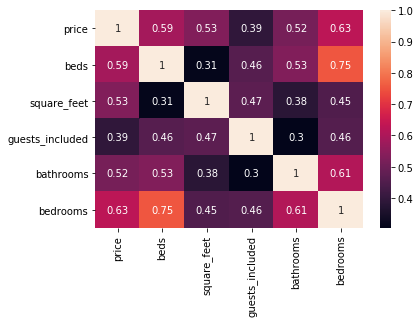

In [28]:
test_df = listing_df[['price', 'beds', 'square_feet', 'guests_included', 'bathrooms', 'bedrooms']]
sns.heatmap(test_df.corr(), annot=True);

Size & Price

In [29]:
apt_cols

['property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet']

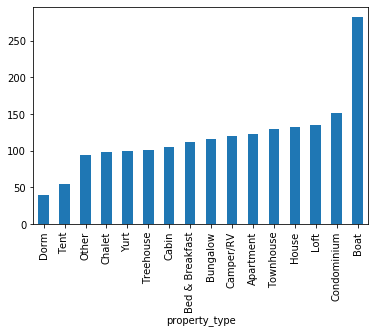

In [30]:
listing_df.groupby('property_type').mean()['price'].sort_values().plot(kind='bar');

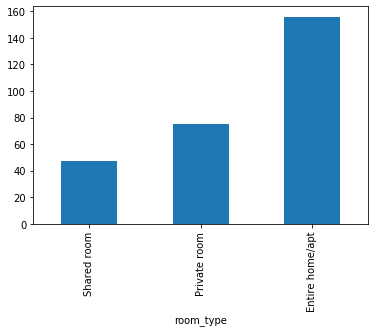

In [31]:
listing_df.groupby('room_type').mean()['price'].sort_values().plot(kind='bar');

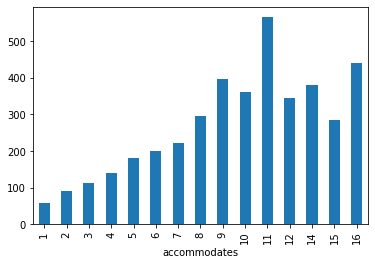

In [32]:
listing_df.groupby('accommodates').mean()['price'].plot(kind='bar');

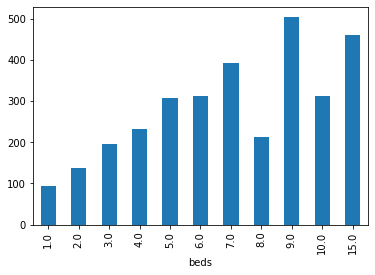

In [33]:
listing_df.groupby('beds').mean()['price'].plot(kind='bar');

### Questions

- How to be a great AirBnB host? Do certain host characteristics relate to better reviews? 
- Are Superhosts more sucessful? 
- Where are the most expensive properties located? Does that reflects the current real state prices of the neighbourhood?
- What influences price?
- Are most expensive listings actually better reviewed?
- How does price fluctuate through the year?
- How is price distributed? How do two cities compare?
- Which words are most common in reviews?
- How do ammenities affect the price?
- Which neighbourhoods have the most expensive listings?

### How does availability and price fluctuate through the year?

In [34]:
#Cleaning calendar data
calendar_df = pd.read_csv('./calendar_seattle.csv')
#price from string to float
calendar_df['price'] = calendar_df['price'].apply(lambda x: clean_price(x))
#available from string to int (1 if t, 0 if f)
calendar_df['available'] = pd.get_dummies(calendar_df['available'], drop_first=True)

In [35]:
#Converting strings to dates
calendar_df['date'] = (calendar_df['date'].apply(datetime.strptime, args=('%Y-%m-%d',)))

In [36]:
#mean availability per listing
avai_list = calendar_df.groupby('listing_id').mean()['available']

In [37]:
calendar_df['date'].value_counts()

2016-12-27    3818
2016-01-17    3818
2016-12-15    3818
2016-09-09    3818
2016-11-07    3818
              ... 
2016-06-10    3818
2016-03-31    3818
2016-10-06    3818
2016-11-08    3818
2016-07-24    3818
Name: date, Length: 365, dtype: int64

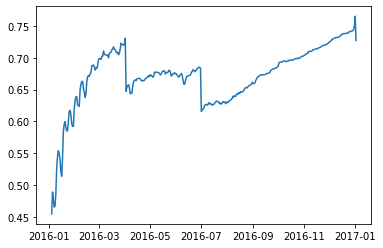

In [38]:
#changes over time on availability
#more houses were in airbnb 

time_df = calendar_df.groupby('date').mean().reset_index()

plt.plot(time_df['date'], time_df['available']);

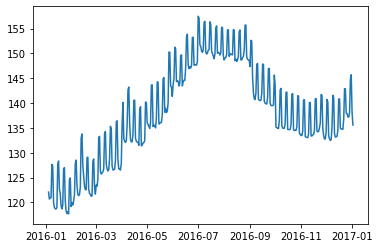

In [39]:
#Seattle beer fest, pride, 4th of July and seafair https://www.tripsavvy.com/seattle-summer-festivals-2964736
# Weekend price
plt.plot(time_df['date'], time_df['price']);

## 1. Are Superhosts more sucessful? 

As an AirBnB client, I have asked myself: what characterizes a "Superhost"? For me, the category was a synonym of better quality, as a "stamp of approval" from AirBnB itself, but also higher prices.

Based on the Seattle AirBnB data, I would like to know - are "Superhosts" actually better reviewed? And does the "Superhost" Badge mean higher prices? Let's find out!

### 1.1. Price: are Superhosts in Seattle able to charge more?

#### 1.1.1. Descriptive Statistics and t-tests

   In this first section, I have calculated descriptive statistics for both the Superhost and the Regular (non-Superhost) groups. Then I performed t-tests to compare these samples and reach conclusions about the data.

   Even though I'd love to stretch my findings for all US Airbnb listings, Seattle cannot be considered a random sample of listings. Refer to this paper for more information: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3105563/

In [40]:
# Checking for missing values in the price column
# As expected, there isn't any - everyone wants to be paid!

listing_df['price'].isnull().mean()

0.0

In [134]:
# Total price column:
# price/night + cleaning fee (if any)

listing_df['total_price'] = (listing_df['price']
                            + listing_df['cleaning_fee'].fillna(0))

# Hosts can also charge security deposits
# Those are a guarantee in case the property is damaged
# The guest accepts to pay it in case of damage

listing_df['sec_price'] = (listing_df['total_price']
                          + listing_df['security_deposit'].fillna(0))

In [135]:
# Dataframe for superhosts:

super_df = listing_df[listing_df['host_is_superhost'] == 't']

# Dataframe for regular hosts:

reg_df = listing_df[listing_df['host_is_superhost'] == 'f']

In [136]:
# Max and Min Values for price

# Superhost:

print('Superhosts: Max.price/night USD {:.2f}, Max.total price USD {:.2f}'.
      format(max(super_df['price']), max(super_df['total_price'])))

# Regular host:

print('Regular hosts: Max.price/night USD {:.2f}, Max.total price USD {:.2f}'.
      format(max(reg_df['price']), max(reg_df['total_price'])))

Superhosts: Max.price/night USD 750.00, Max.total price USD 1050.00
Regular hosts: Max.price/night USD 1000.00, Max.total price USD 1275.00


In [138]:
# Relevant Price Columns in Listings_df:

price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'total_price', 'sec_price']

# Superhost Average Price Parameters:

super_pri_mean = pd.DataFrame(super_df[price_cols].mean())

# Regular host Average Price Parameters:

reg_pri_mean = pd.DataFrame(reg_df[price_cols].mean())

In [139]:
def two_tail_t_test(reg_df, super_df, col, alpha):
    
    '''
    INPUT:
    reg_df - the first pandas dataframe to compare in a t-test
    super_df - the second pandas dataframe to compare in a t-test
    col - the column name to be compared
    size - how big should the bins in your histogram be
    
    OUTPUT:
    Displays a double-histogram plot and the 25%, 50% and 75% percentiles 
    '''

    # T-test for total prices (price per night + cleaning fee + security deposit)
    # Comparing Superhosts and regular hosts

    # Calculating regular host parameters

    sample_r = reg_df.shape[0]
    mean_sample_r = reg_df[col].mean()
    stdev_sample_r = statistics.stdev(reg_df[col])
    sum_squares_r = reg_df[col].var(ddof=1)*(sample_r-1)

    # Calculating superhost parameters

    sample_s = super_df.shape[0]
    mean_sample_s = super_df[col].mean()
    stdev_sample_s = statistics.stdev(super_df[col])
    sum_squares_s = super_df[col].var(ddof=1)*(sample_s-1)

    # Independent samples t-test 
    # Degrees of freedom:

    deg_f = sample_r + sample_s - 2

    # Pooling variances for a more precise result

    pool_var = (sum_squares_r + sum_squares_s)/deg_f

    # Corrected Standard Error

    st_error = np.sqrt((pool_var/sample_r) + (pool_var/sample_s))

    # Calculating t-statistics

    t = (mean_sample_s - mean_sample_r)/st_error

    # For the alpha value we find our t-critical value (two-tailed)

    t_crit = -stats.t.ppf(alpha/2, deg_f)

    return t, t_crit

In [143]:
# Two-tailed Hypothesis Test: Security Price Results (price/night + cleaning fee + security deposit)

print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average total price + security deposit'
      ' and superhosts average total price +  security deposit'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average total price + security deposit'
      ' and superhosts average total price + security deposit' '\n')

# Running the test with alpha = 0.01

t, t_crit = two_tail_t_test(reg_df, super_df, 'sec_price', 0.01)

# Commenting Results

print('Our t statistic {:.2f} is greater than the t critical value {:.2f}, thus it is in the critical zone.'
      .format(t, t_crit))

print('\n''The result is statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''If we consider the security deposit, Seattle Superhosts seem to charge more than regular hosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average total price + security deposit and superhosts average total price +  security deposit

Alternative Hypothesis: There is a significant difference between regular hosts average total price + security deposit and superhosts average total price + security deposit

Our t statistic 2.78 is greater than the t critical value 2.58, thus it is in the critical zone.

The result is statistically significant for alpha = 0.01.

If we consider the security deposit, Seattle Superhosts seem to charge more than regular hosts.


In [145]:
# Two-tailed Hypothesis Test: Total Price Results (price/night + cleaning fee)

print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average price/night and superhosts average price/night'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average price/night and superhosts average price/night' '\n')

# Running the test with alpha = 0.01

t, t_crit = two_tail_t_test(reg_df, super_df, 'total_price', 0.01)

# Commenting Results

print('Our t statistic {:.2f} is between the the t critical values ±{:.2f}, thus it is outside of critical zone.'
      .format(t, t_crit))

print('\n''The result is NOT statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''When it comes to price per night + cleaning fee, we do not observe'
        ' significant differences between regular and superhosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average price/night and superhosts average price/night

Alternative Hypothesis: There is a significant difference between regular hosts average price/night and superhosts average price/night

Our t statistic 0.79 is between the the t critical values ±2.58, thus it is outside of critical zone.

The result is NOT statistically significant for alpha = 0.01.

When it comes to price per night + cleaning fee, we do not observe significant differences between regular and superhosts.


In [146]:
# Two-tailed Hypothesis Test: Price/Night Results

print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average price/night and superhosts average price/night'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average price/night and superhosts average price/night' '\n')

# Running the test with alpha = 0.01

t, t_crit = two_tail_t_test(reg_df, super_df, 'price', 0.01)

# Commenting Results

print('Our t statistic {:.2f} is between the the t critical values ±{:.2f}, thus it is outside of critical zone.'
      .format(t, t_crit))

print('\n''The result is NOT statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''When it comes to price per night, we do not observe significant differences between regular and superhosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average price/night and superhosts average price/night

Alternative Hypothesis: There is a significant difference between regular hosts average price/night and superhosts average price/night

Our t statistic 0.76 is between the the t critical values ±2.58, thus it is outside of critical zone.

The result is NOT statistically significant for alpha = 0.01.

When it comes to price per night, we do not observe significant differences between regular and superhosts.


#### 1.1.2. Deep Dive: Comparing Price/Night and Total Price

   These intriguing results require further investigation - Superhosts clearly charge more in total, but when we do not consider cleaning fees and security deposits, the difference vanishes. 

In [148]:
# Creating DataFrames with the % of non-missing values in each price column

super_nan = pd.Series(dtype= np.float64)
reg_nan = pd.Series(dtype=np.float64)

for col in price_cols:
    super_nan = super_nan.append(pd.Series([100*(1 - super_df[col].isnull().mean())], index = [col]))
    reg_nan = reg_nan.append(pd.Series([100*(1 - reg_df[col].isnull().mean())], index = [col]))
    
super_nan = pd.DataFrame(super_nan)
reg_nan = pd.DataFrame(reg_nan)

In [149]:
# Analyzing percentage of non-missing values and the means of the three price components:

comp_df = pd.concat([super_pri_mean, super_nan, reg_pri_mean, reg_nan], axis=1, sort=False)
comp_df.columns = ['Superhosts', '% of Listings S', 'Regular Hosts', '% of Listings R']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']

# Conclusions:

print('{:.1f}% of Superhosts charge a security fee, whereas {:.1f}% of regular hosts do so.'
      .format(super_nan.loc['security_deposit', :][0], reg_nan.loc['security_deposit', :][0]))
print('{:.1f}% of Superhosts charge a cleaning fee, whereas {:.1f}% of regular hosts do so.'
       .format(super_nan.loc['cleaning_fee', :][0], reg_nan.loc['cleaning_fee', :][0]))
print('Significant prices differences are likely due to these extra charges, which are more common ' 
      'among Superhosts.')

# Show Results

comp_df = comp_df.round(1)
comp_df.style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

58.9% of Superhosts charge a security fee, whereas 46.3% of regular hosts do so.
79.3% of Superhosts charge a cleaning fee, whereas 71.4% of regular hosts do so.
Significant prices differences are likely due to these extra charges, which are more common among Superhosts.


,Superhosts,% of Listings S,Regular Hosts,% of Listings R,Delta
price,130.100000,100.000000,127.400000,100.000000,2.700000
weekly_price,824.300000,58.900000,777.700000,51.000000,46.700000
monthly_price,2981.000000,47.000000,2495.500000,37.900000,485.500000
security_deposit,280.400000,58.900000,289.900000,46.300000,-9.500000
cleaning_fee,58.100000,79.300000,62.800000,71.400000,-4.700000
guests_included,1.800000,100.000000,1.600000,100.000000,0.200000
extra_people,12.100000,100.000000,10.300000,100.000000,1.800000
total_price,176.200000,100.000000,172.200000,100.000000,4.000000
sec_price,341.300000,100.000000,306.600000,100.000000,34.700000


#### 1.1.3. Visualizing our Data

Plots help Medium readers to visualize our findings and to understand what story our data tells.

In [150]:
def hist_generator(reg_df, super_df, col, size, max_range_99=False, percentil=True, xmin=0):
    
    '''
    INPUT:
    reg_df - the first pandas dataframe whose column you want to plot
    super_df - the second pandas dataframe whose column you want to plot
    col - the column name you want to plot
    size - how big should the bins in your histogram be
    max_range_99 - if true, sets the x-axis maximum value to the 99% quartile.
                   Default is false to show all values.
    percentil - True (default) to plot percentile values and axis
    xmin - minimal x value on the plot. Zero as default.
    
    OUTPUT:
    Displays a double-histogram plot and the 25%, 50% and 75% percentiles 
    '''
    
    # Basis for the analysis

    super_price = super_df[col]
    reg_price = reg_df[col]
        
    if max_range_99 == True:
        # We'll show 99% of the data to exclude outliers
        max_range = int(max(reg_price.quantile(0.99), 
                    super_price.quantile(0.99)))
    else:
        # Max Range is the maximum value of the distributions
        max_range = max(int(super_price.max()) + 1,
                        int(reg_price.max()) + 1)

    # Defining bin size to optimize visualization
    
    bin_size = list(np.arange(xmin, max_range + 1, size))

    # Defining weights for each distribution
    # that is, the basis for the percentage - samples have different sizes!

    basis_super = np.ones(len(super_price)) / len(super_price)
    basis_reg = np.ones(len(reg_price)) / len(reg_price)

    # Plotting the histogram

    fig = plt.figure(figsize = (15,10))
    plt.hist([reg_price, super_price], weights = [basis_reg, basis_super], alpha=0.5, bins=bin_size)

    # Formatting percentages, legends and axis labels

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
    plt.legend(['Regular hosts', 'Superhosts']);
    plt.ylabel('Percentage of listings (%)');
    plt.xlabel(col.capitalize());
    plt.xticks(list(np.arange(xmin, max_range, 2*size)));
    plt.title(col.capitalize() + ': Superhosts vs. Regular hosts' );

    # Adding 25%, 50% and 75% Percentiles
    
    if percentil == True:
        reg_quantile = reg_price.quantile([0.25,0.5,0.75])
        super_quantile = super_price.quantile([0.25,0.5,0.75])
        min_ylim, max_ylim = plt.ylim()
        delta = 0.01

        for idx, item in enumerate(reg_quantile):
            plt.axvline(item, color='C0', linestyle='dashed', linewidth=1)
            plt.text(item + 10, max_ylim - delta, '{}. Quartile: {:.2f}'.format(idx + 1, item), color ='C0')
            delta += 0.01

        for idx, item in enumerate(super_quantile):
            plt.axvline(item,  color='orange', linestyle='dashed', linewidth=1)
            plt.text(item + 10, max_ylim - delta, '{}. Quartile: {:.2f}'.format(idx + 1, item), color = 'orange')
            delta += 0.01
    
    plt.show()

In [151]:
def cummulative_hist(reg_df, super_df, col, size, max_range_99=False, xmin=0):
    '''
    INPUT:
    reg_df - the first pandas dataframe whose column you want to plot
    super_df - the second pandas dataframe whose column you want to plot
    col - the column name you want to plot
    size - how big should the bins in your cummulative histogram be
    max_range_99 - if true, sets the x-axis maximum value to the 99% quartile.
                   Default is false to show all values.
    xmin - minimal x value on the plot. Zero as default.
    
    OUTPUT:
    Displays a cummulative histogram plot for both data frames' column.
    '''
    
    # Basis for the analysis

    reg_price = reg_df[col]
    super_price = super_df[col]

    if max_range_99 == True:
        # We'll show 99% of the data to exclude outliers
        max_range = int(max(reg_price.quantile(0.99), 
                    super_price.quantile(0.99)))
    else:
        # Max Range is the maximum value of the distributions
        max_range = max(int(super_price.max()) + 1,
                        int(reg_price.max()) + 1)
    
    # Defining bin size to optimize visualization
    
    bin_size = list(np.arange(xmin, max_range, size))

    # Plotting the histogram
    
    fig = plt.figure(figsize = (15,10))
    plt.hist([reg_price, super_price], density = True, 
             histtype='step', fill=False, cumulative=True, bins=bin_size, color = ['C0', 'orange'])

    # Formatting percentages, legends and axis labels

    plt.grid(True, alpha=0.5)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
    plt.legend(['Superhosts', 'Regular hosts']);
    plt.ylabel('Percentage of listings - Cummulative (%)');
    plt.xlabel(col.capitalize());
    plt.title(col.capitalize() +': Superhosts vs. Regular hosts');

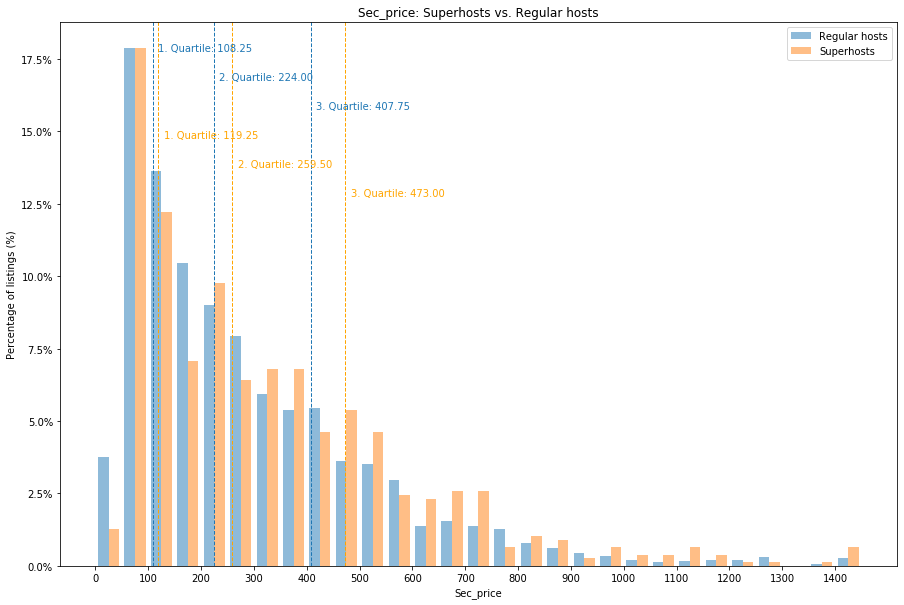

In [155]:
# Total Price + Security Deposit Histogram - bin size = 50 - outliers (top 1% most expensive) are not shown

hist_generator(reg_df, super_df, 'sec_price', 50, max_range_99=True)

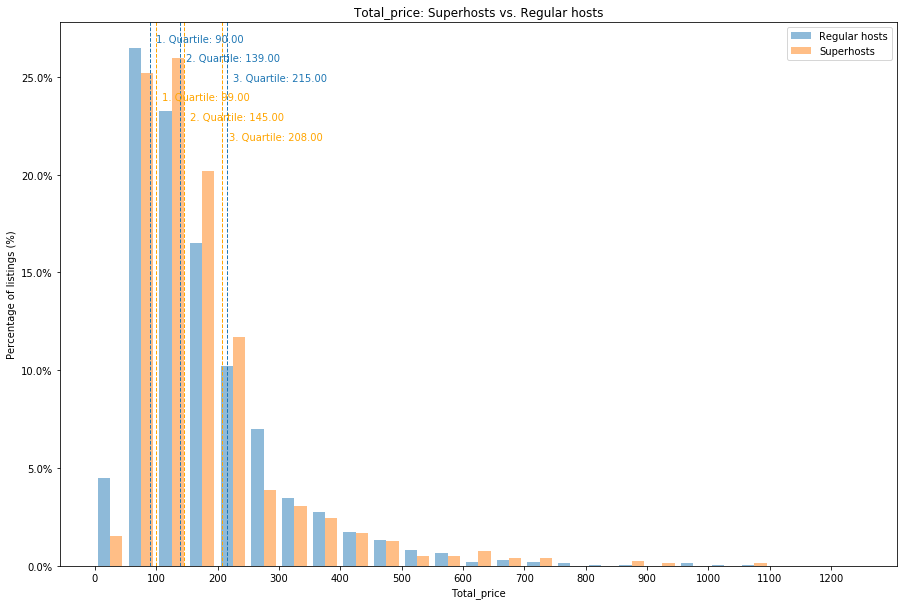

In [156]:
# Total Price Histogram - bin size = 50 

hist_generator(reg_df, super_df, 'total_price', 50)

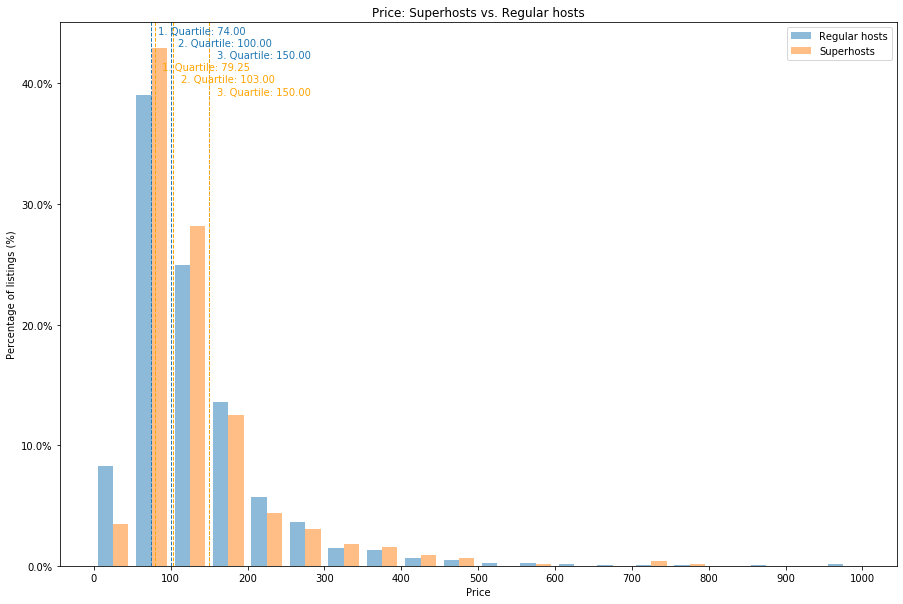

In [157]:
# Price Histogram - bin size = 50 

hist_generator(reg_df, super_df, 'price', 50)

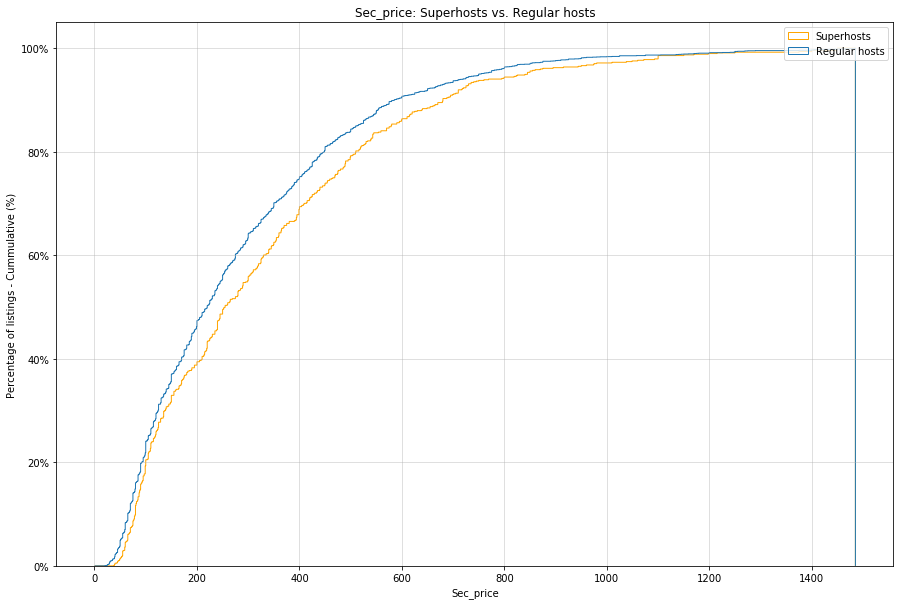

In [158]:
# Total Price + Security Deposit Cummulative Histogram - bin size = 1 - outliers (top 1% most expensive) are not shown

cummulative_hist(reg_df, super_df, 'sec_price', 1, max_range_99=True)

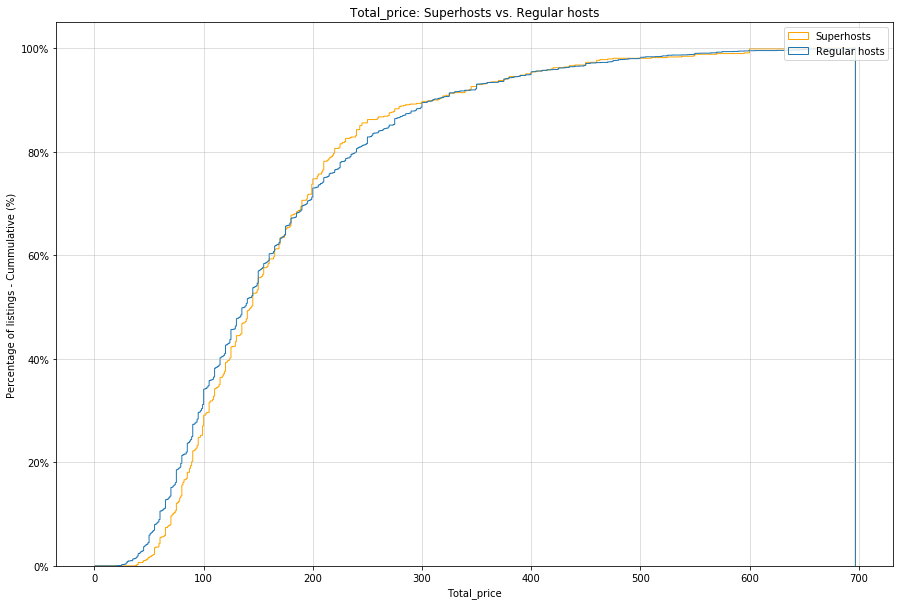

In [162]:
# Total Price Cummulative Histogram - bin size = 1 - outliers (top 1% most expensive) are not shown

cummulative_hist(reg_df, super_df, 'total_price', 1, max_range_99=True)

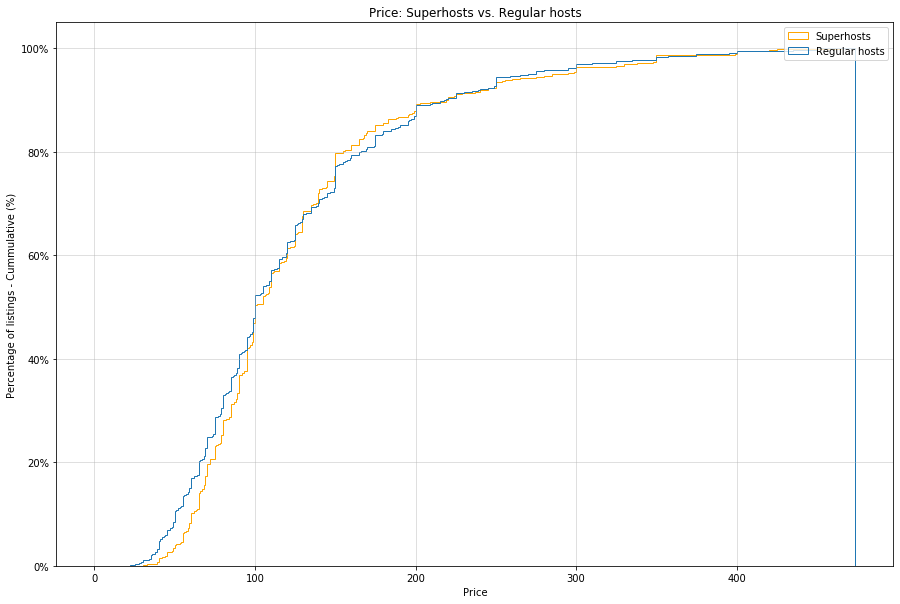

In [165]:
# Price Cummulative Histogram - bin size = 1 - outliers (top 1% most expensive) are not shown

cummulative_hist(reg_df, super_df, 'price', 1, max_range_99=True)

### 1.2. Reviews: are Superhosts in Seattle better reviewed?

#### 1.2.1. Descriptive Statistics and t-tests

   In this Section, I tried to understand the meaning behind the review data, and how the mean values differ from superhosts to regular hosts. Statistical tests were used to gauge the mean review differences.

In [166]:
# Relevant Review Columns in Listings_df:

rev_cols = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location', 
            'review_scores_value', 'reviews_per_month']

# Superhost Average Review Parameters:

super_rev_mean = pd.DataFrame(super_df[rev_cols].mean())

# Regular host Average Review Parameters:

reg_rev_mean = pd.DataFrame(reg_df[rev_cols].mean())

#### 1.2.2. Deep Dive: Reviews Categories

The previous results are interesting - some review categories are less often reviewed than others, that is, they have more missing values. In this section, I will further investigate the dataset to draw insights on the reviewing process.

In [167]:
# Creating DataFrames with the % of non-missing values in each price column

super_nan = pd.Series(dtype=np.float64)
reg_nan = pd.Series(dtype=np.float64)

for col in rev_cols:
    super_nan = super_nan.append(pd.Series([100*(1 - super_df[col].isnull().mean())], index = [col]))
    reg_nan = reg_nan.append(pd.Series([100*(1 - reg_df[col].isnull().mean())], index = [col]))
    
super_nan = pd.DataFrame(super_nan)
reg_nan = pd.DataFrame(reg_nan)

In [168]:
# Analyzing percentage of non-missing values and the means of the three price components:

comp_df = pd.concat([super_rev_mean, super_nan, reg_rev_mean, reg_nan], axis=1, sort=False)
comp_df.columns = ['Superhosts', '% of Listings S', 'Regular Hosts', '% of Listings R']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']

# Conclusions:

print('{:.1f}% of Superhost Listings are yet to be reviewed'
      .format(100 - super_nan.loc['review_scores_rating', :][0]))
print('{:.1f}% of regular host Listings are yet to be reviewed'
      .format(100 - reg_nan.loc['review_scores_rating', :][0]))
print('One observes that Superhosts receive on average three times as much reviews as their regular counterparts.')
print('Accuracy and Check-In are less often reviewed among regular hosts.')

# Show Results

comp_df.round(1).style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

3.5% of Superhost Listings are yet to be reviewed
20.3% of regular host Listings are yet to be reviewed
One observes that Superhosts receive on average three times as much reviews as their regular counterparts.
Accuracy and Check-In are less often reviewed among regular hosts.


,Superhosts,% of Listings S,Regular Hosts,% of Listings R,Delta
number_of_reviews,41.800000,100.000000,17.200000,100.000000,24.500000
review_scores_rating,97.400000,96.500000,93.700000,79.700000,3.700000
review_scores_accuracy,9.900000,96.500000,9.600000,79.300000,0.400000
review_scores_cleanliness,9.900000,96.500000,9.500000,79.500000,0.400000
review_scores_checkin,10.000000,96.500000,9.700000,79.300000,0.200000
review_scores_communication,10.000000,96.500000,9.800000,79.500000,0.200000
review_scores_location,9.800000,96.500000,9.600000,79.400000,0.200000
review_scores_value,9.700000,96.500000,9.400000,79.400000,0.400000
reviews_per_month,3.000000,96.500000,1.800000,80.300000,1.200000


#### 1.2.3. Statistical tests

The comparison between overall ratings from superhosts and regular hosts can now be performed. I have later found out that Superhosts are chosen based on their overall ratings, so the higher mean rating makes a lot of sense!

In [169]:
# Dropping NaN Values in the weighted rating column:

super_reviews = super_df[rev_cols].dropna(subset=['review_scores_rating'])
reg_reviews = reg_df[rev_cols].dropna(subset=['review_scores_rating'])

In [170]:
# Two-tailed Hypothesis Test: Total Price Results

print('\033[1m' 'Two-tailed Statistical Significance Test (alpha = 0.01):''\033[0m' '\n''\n'
      '\033[1m' 'Null Hypothesis:''\033[0m'
      ' No significant difference between regular hosts average rating and superhosts average rating'  '\n' '\n'
      '\033[1m' 'Alternative Hypothesis:''\033[0m'
      ' There is a significant difference between regular hosts average rating and superhosts average rating' '\n')

# Running the test with alpha = 0.01

t, t_crit = two_tail_t_test(reg_reviews, super_reviews, 'review_scores_rating', 0.01)

# Commenting Results

print('Our t statistic {:.2f} is greater than the t critical value {:.2f}, thus it is in the critical zone.'
      .format(t, t_crit))

print('\n''The result is statistically significant for alpha = 0.01.' '\n''\n'
        '\033[1m''Seattle Superhosts seem to be better reviewed than regular hosts.')

Two-tailed Statistical Significance Test (alpha = 0.01):

Null Hypothesis: No significant difference between regular hosts average rating and superhosts average rating

Alternative Hypothesis: There is a significant difference between regular hosts average rating and superhosts average rating

Our t statistic 13.97 is greater than the t critical value 2.58, thus it is in the critical zone.

The result is statistically significant for alpha = 0.01.

Seattle Superhosts seem to be better reviewed than regular hosts.


#### 1.2.4. Visualizing our Data

Plots help Medium readers to visualize our findings and to understand what story our data tells.

When observing single review categories, the difference between Superhosts and regular hosts ratings is not substantial.
Superhosts perform especially better in cleaninless and price/value categories.


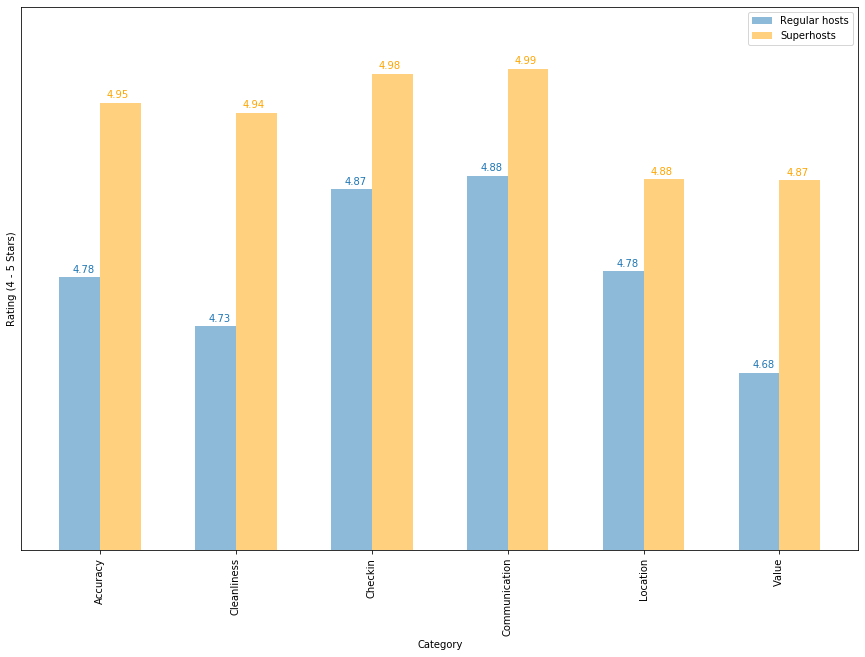

In [171]:
# Bar plots of the mean reviews per category
# Comparison between Regular and Superhosts

# Selecting the relevant rows from comp_df
# We only want the review scores dimensions
# Note that review_scores_rating is a weighted average from the other review scores 

plot_df = comp_df.drop(['number_of_reviews', 'reviews_per_month', 'review_scores_rating'], axis = 0)

# Guests are able to rate hosts from 1 to 5 stars
# Rescale to plot correct ratings

plot_df = plot_df/2

# Cleaning indexes for better looking x-ticks

remove_scores = lambda x: (x.replace('review_scores_', '')).capitalize()
x_names = pd.Series(plot_df.index).apply(remove_scores)

# Creating figures

fig = plt.figure(figsize = (15,10))
ax1 = plt.subplot(1,1,1)

# x_axis and width help to set bar plots next to each other

x_axis = np.arange(len(plot_df.index))
w = 0.3

# Plotting our bar graphs

reg_p = ax1.bar(x_axis, plot_df['Regular Hosts'], width=w, color='C0', alpha=0.5, align='center')
super_p = ax1.bar(x_axis + w, plot_df['Superhosts'], width=w,color='orange', alpha=0.5, align='center')

# Adding values over bars

for index, value in enumerate(plot_df['Regular Hosts']):
     plt.text(index-0.05, value*1.001, str(round(value,2)), color = 'C0')
        
for index, value in enumerate(plot_df['Superhosts']):
     plt.text(index+0.2, value*1.001, str(round(value,2)), color = 'orange')

# Ticks and Labels

plt.xticks(x_axis + w /2, x_names, rotation='vertical');
plt.yticks([]);
plt.legend([reg_p, super_p],['Regular hosts', 'Superhosts']);
plt.ylabel('Rating (4 - 5 Stars)');
plt.ylim(4.5,5.05)
plt.xlabel('Category');

# Commentary

print('When observing single review categories, the difference between Superhosts'
      ' and regular hosts ratings is not substantial.')
print('Superhosts perform especially better in cleaninless and price/value categories.')

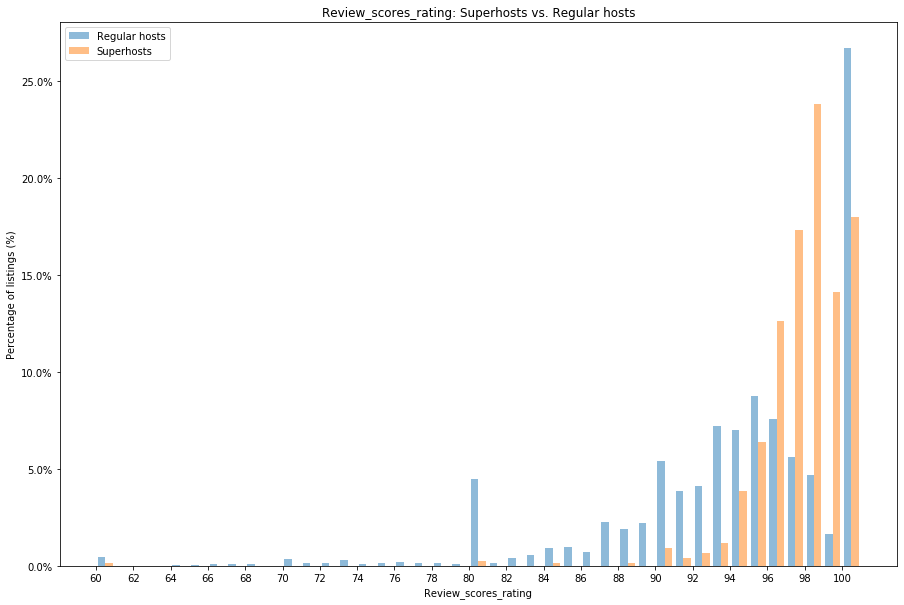

In [172]:
# Histogram of ratings
# The smallest value on the x-axis is obtained 
# via the smallest 1% percentile between regular and superhosts

worst_review = min(super_reviews['review_scores_rating'].quantile(0.01), reg_reviews['review_scores_rating'].quantile(0.01))
hist_generator(reg_reviews, super_reviews, 'review_scores_rating', 1, percentil=False, xmin=int(worst_review/10)*10)

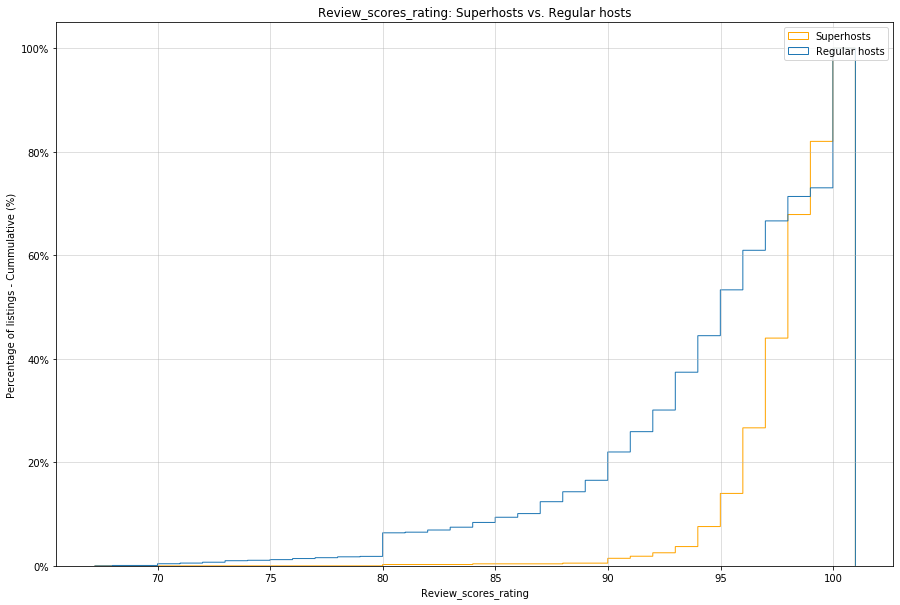

In [173]:
# Cummulative histogram of ratings

cummulative_hist(reg_reviews, super_reviews, 'review_scores_rating', 0.01, xmin = worst_review)

## 2. The Relationship between Price and Location

As a rule of thumb, we expect prices to be correlated with location - the better the neighborhood, the higher the price. I am interested in finding out if this is actually true. I will also compare the AirBnB data with the current real state prices in the neighborhoods, and find out if there is any correlation between these values. 

Based on the Seattle AirBnB data, I would like to know - do the most expensive neighborhoods in Seattle have the most expensive Airbnb listings? Let's find out!

In [188]:
# Creating data frame with neighbourhood cleansed name, price and total price (price + cleaning) of listing
# as well as location data

price_loc_df = listing_df[['neighbourhood_cleansed', 'latitude', 'longitude', 'price', 'total_price']]

# Finding the mean price & total price per neighbourhood
# Sorting df per price, descending

price_rank = price_loc_df.groupby('neighbourhood_cleansed').mean().sort_values(by='price', ascending=False)

# Finding the number of listings per neighbourhood

number_lists = price_loc_df.groupby('neighbourhood_cleansed').count().rename(columns={'price':'count'})['count']

# Concatenating both dataframes

rank_neig = pd.concat([price_rank, number_lists], axis=1, sort=False)

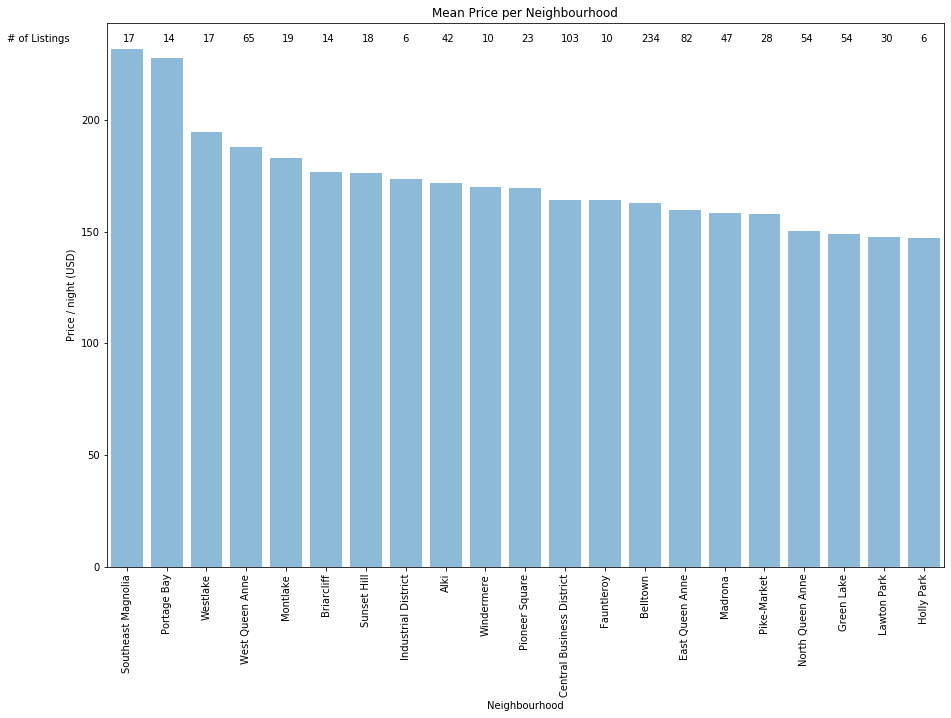

In [250]:
# Plotting mean prices and number of listings per Neighbourhood
# 20 Most Expensive Neighbourhoods

# Creating figures

fig = plt.figure(figsize = (15,10))
ax1 = plt.subplot(1,1,1)

# Plotting our bar graphs

price = ax1.bar(rank_neig.index, rank_neig['price'], color='C0', alpha=0.5, align='center')
        
# Ticks and Labels

plt.xticks(x_axis, x_names, rotation='vertical');
plt.xlim(-0.5,20.5);
plt.ylabel('Price / night (USD)');
plt.xlabel('Neighbourhood');
plt.title('Mean Price per Neighbourhood')

# Adding number of listings

plt.text(-3, 235, '# of Listings')

for index, value in enumerate(rank_neig['price']):
    if index <= 20:
        plt.text(index-0.1, 235, str(rank_neig['count'][index]))
    else:
        break

In [251]:
# The bar plot is not a perfect visualization
# In order to improve it, let's try a bubble plot map!

# Bubble Colors will represent the mean price of the listings

c = rank_neig['price']

# Bubble Size will represent the number of listings

s = rank_neig['count']

# Scatter plot with longitude (y) and latitude (x)

line_plot_fig, line_plot_ax = plt.subplots(figsize=(15,10))
graph = line_plot_ax.scatter(rank_neig['longitude'], rank_neig['latitude'], c=c, cmap = 'RdPu', s = s*10);

# Generate html-file with the map 

mplleaflet.show(fig=line_plot_fig, tiles='cartodb_positron', path='seattlemap.html')

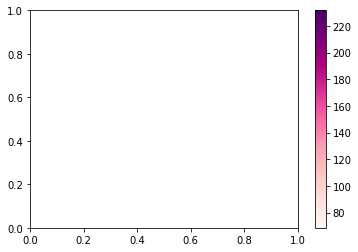

In [218]:
# Color 

plt.colorbar(graph);

In [84]:
# Creating new dataframe with the 10% most expensive listings
# and a second one with the other 90%

exp_df = listing_df[listing_df['price'] >= listing_df['price'].quantile(0.8)]
che_df = listing_df[listing_df['price'] < listing_df['price'].quantile(0.8)]

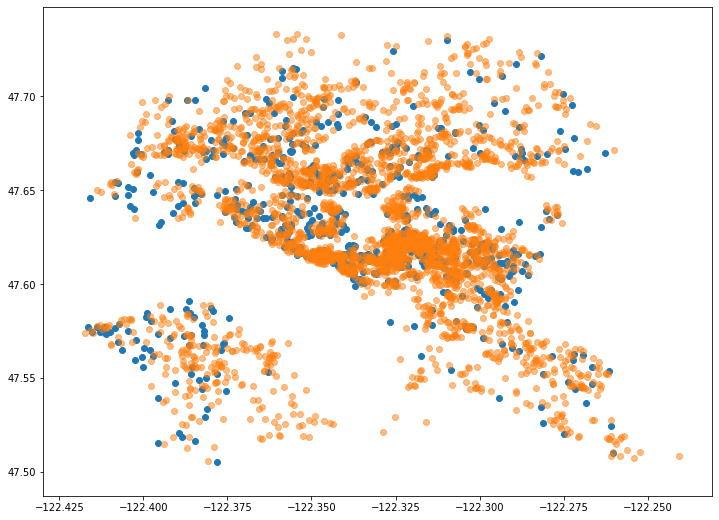

In [85]:
c = listing_df['price'].sort_values()
line_plot_fig, line_plot_ax = plt.subplots(figsize=(12,9))
line_plot_ax.scatter(exp_df['longitude'], exp_df['latitude']);
line_plot_ax.scatter(che_df['longitude'], che_df['latitude'], alpha=0.5);

In [ ]:
mplleaflet.show(fig=line_plot_fig, tiles='cartodb_positron', path='seattlemap.html')